### Problem 1
Pin-hole cameras are well described by projective camera model, which means that there exists a projective transform that maps point from world coordinate system to the image coordinate systems.

a) Projective transforms are "linear" in homogenious coordinates, and they map straight lines into straight lines.

b) Projective transforms do not preserve angles. The simplest counter-example is a pair of two straight lines in the world space that go from camera to the horizon ("rail road"). In the world space two lines are parallel, while in image space the images of two lines intersect in a so called vanishing point.


### Problem 2
In this ideal case apparent motion of the points is caused by actual movement of the ground plane (in drone coordinate system).

If ground plane has such a consistent unique texture(e.g. short grass) to compute optical flow in every point, it will be actually the same everywhere and be counter-directed to the drone velocity.

However it is unlikely that ground will be absolutely flat and have enough texture to compute optical flow reliably for every pixel, so there will be some regions with close to zero or noisy optical flow. Also if height is not constant across the imaged area, optical flow magnitude can vary even when the direction is the same.

To calculate "effective" optical flow, one could average optical flow, or calculate it's median. 

Once we have this "effective" estimation of total optical flow `dU`, we can use `dX/h = -du/F`, which means `dX = -du * h / F`.

If we calculate optical flow every `dt` seconds, the drone velocity `V = - du / dt * h / F`


### Problem 3
Moving towards the plane orthoganlly, every pixel of a plane will move from the expected point-of-collision to the border of the frame.

If the plane is normal to the optical axis, the optical flow will look like concentrical circles. If there is some angle betwenn the axis and the plane - it will look as a ellispis.

If we approximate drone as a point whose speed is always codirectional with optical axis, than we can determine qualitatively that there going to be a collision if the optical flow in the center of the image has a far-from-zero divergence - that means that all neighbour pixels are "moving away" from the center, and drone is going to collide.


Since `y` is defined relative to the intersection point of plane and optical axis:
- `u/f = y/x`
- `(u + du)/f = y / (x - dx) = y/x /(1 - dx/x) ~y/x * (1 + dx/x)`

`u/f + du/f = y/x + 1/n (y/x)`

`du/f = 1/n( u/f)`

`n = u/du`

`t = n * dt = u * dt/du`

This shows that given 2 consecutive measurements which belong to the same reference point in the world coordinate system, it is possible to calculate time-to-collision.

This result looks reasonable:
- in the u=0 we can't get any estimate - this point is supposed to be stable since drone is going to collide into it
- if we get high optical flow close to the principal point - that means that features are leaving field-of-view very fast, and drone is going to collide soon - and so `t` is low


# Lab 7: Optical Flow (40 Pts)

In this lab, we are going to implement the optical flow algorithm we discussed in class. Optical flow is a very useful algorithm for a wide variety of robotics tasks, including state estimation, tracking objects, and dynamically avoiding obstacles. It's also very straightforward to implement. 

Before we begin, you need to install FFMPEG to run this assignment. To do so, run `sudo apt install ffmpeg` (Linux) or `brew install ffmpeg` (Mac) in your terminal. Instructions for doing so may be found in previous labs (e.g. Lab 2). You may also need to install opencv using the following command in Anaconda Prompt (be sure the MAE345 environment is activated): `pip install opencv-python`

Also, you should be aware that a couple of the cells in this notebook render videos. While designing the assignment, the instructors found that Jupyter continues to store previous videos in memory if you rerun the cell multiple times. As a result, your computer may run out of RAM if you run the cell too many times. If this does occur, you can kill the Jupyter process in the terminal by pulling up the terminal window running Jupyter and hitting `Ctrl+C`.

In this lab, you will record a video with your crazyflie and run optical flow on this video.

Let's start by testing the camera module.

**Please note: You should work with your team to setup the camera/receiver and record the video, but you must complete the optical flow portion of the assignment individually. So, every team member should submit their own completed notebook along with the two video files produced.**

### Instructions for adding camera module for crazyflie

Remove the battery retainer, the optical flow module, and the pins attached to your board. The camera module will act as the battery holder and also keep the optical flow module attached. **Carefully** push the camera module where the battery retainer was until the pins stick out of the botton of the main body, ensure that it is facing foward on the drone and that there is enough room for the battery to slip between the main board and the camera module. Replace the optical flow board on these pins and position it as it was before. A picture is provided in `Lab7-photos`.

Next, we can use cv2 to recieve the video from the camera and view it on this computer. Begin by pluggin your receiver into this computer and then run the following cell. If the cell reports an error, ensure that opencv-python is properly installed (see above). After installing, restart the kernel.

A window which is probably showing static should appear. Next, we need to tune the receiver and camera module so they are on the same channel. The two buttons on the receiver change the received frequency down (left button) or up (right button) by 2 MHz. If you hold down the up button for a few seconds, the receiver will scan through all possibly frequencies, produce a histogram of the signal vs. frequency, and set the receiver to the frequency with the highest signal. Please note that to use this feature, you must ensure there are no other camera modudules nearby.

Channels on the camera are identified by a `BAND` (blue LED, 1 on the left and 5 on the right) and `CH` (red LED, 1 on the left and 8 on the right), e.g. `BAND1 and CH1` for the two leftmost blue and red LEDs. You can change the `CH` number by pressing the button on the camera and the `BAND` by pressing the button for at least 2 seconds and then releasing. See the chart below for the list of frequencies corresponding to a particular BAND and CH frequency in MHz.

| Channel | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Band 1   | 5865 | 5845 | 5825 | 5805 | 5785 | 5765 | 5745 | 5725 | 
| Band 2   | 5733 | 5752 | 5771 | 5790 | 5809 | 5828 | 5847 | 5866 |
| Band 3   | 5705 | 5685 | 5665 | 5665 | 5885 | 5905 | 5905 | 5905 |
| Band 4   | 5740 | 5760 | 5780 | 5800 | 5820 | 5840 | 5860 | 5880 | 
| Band 5   | 5658 | 5695 | 5732 | 5769 | 5806 | 5843 | 5880 | 5917 |

You will need to set the camera and receiver to operate on the same channel. We want to avoid intereference in the lab spaces when testing on the drone. The receiver has a large enough range that any CH and BAND can be used on the camera and the receiver will be able to pick up on the signal. However, the camera broadcasts strongest in the first 2 BANDS. Please set your camera `CH` to be the remainder of your group number when divided by 8. (i.e. if you're group number 15, you should set the `CH` 7) on Band 1 for groups 1-8, Band 2 for groups 9-16, and Band 3 for groups 17 on. This should avoid most interference but if there are issues in the lab space, you can pick another channel to tune to.

Once you are done tuning, you can press 'q' to kill the window. Note that you may have to restart the kernel by going to the 'Kernel' and clicking 'Restart' as the cv2 window sometimes causes issues with jupyter-notebook.


### The video was recorded using AI-deck

### Instructions for recording video

Next, you will record a video with the camera module so you can perform optical flow on your very own video. The following cell will connect to the camera module on the crazyflie and record a 5-second video. The cell will tell you when the video recording starts and ends. You must manually move the crazyflie during the recording. **Be sure to include a variety of movements, including: moving forward, pan left, pan right.**

The result is a video titled `video_crazyflie.avi`.

Next, let's load in your video and visualize it. The following cell includes helper functions for visualization. **Do not edit this cell!**

In [1]:
import numpy as np
import cv2
import time
from IPython.display import HTML, Image

from matplotlib import pyplot as plt
from matplotlib import animation
from typing import List, Tuple

def load_video(name):
    frames = []
    cap = cv2.VideoCapture(name)
    fps = cap.get(cv2.CAP_PROP_FPS)
    while cap.isOpened():
        ret, frame = cap.read()

        if ret == False:
            break
        else:
            frames.append(frame)

    cap.release()

    I = np.zeros([image_size[1], image_size[0], len(frames)])
    for t in range(len(frames)):
        I[:, :, t] = cv2.cvtColor(cv2.resize(frames[t], image_size), cv2.COLOR_BGR2GRAY) / 255
        
    return I, fps
    
def create_gif(I, frame_rate=20):
    fig, ax = plt.subplots()
    im = ax.imshow(I[:, :, 0], cmap='gray')

    def init():
        return [im]

    def animate(i):
        ax.clear()
        im = ax.imshow(I[:, :, i], cmap='gray')

        return [im]

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=I.shape[2], interval=100, blit=True)

    anim.save('./anim.gif', writer='pillow', fps=frame_rate)
    Image(url='./anim.gif')


The variable `I` contains a grayscale video represented as a numpy array. How videos are represented in numpy is as a three dimensional array. If you want to access the pixel at $(x, y)$ at time $t$, it is stored at `I[y, x, t]`. Moreover, all values in `I` are between 0 (black) and 1 (white).

The next cell creates a `.gif` file of the video so we can take a look at the video in motion. If the video isn't playing in jupyter-notebook, it is also saved as a `.gif` in the same directory as this notebook. Please ensure that the `.gif` file plays correctly on your computer (for Mac/Linux, the file may appear as a sequence of images). **Again, do not edit this cell!**

In [2]:
from pathlib import Path
file_name = str((Path() / "suppl" / "lab7.avi").absolute())
image_size = (320, 320)



Loading video!
Making GIF!
GIF made!


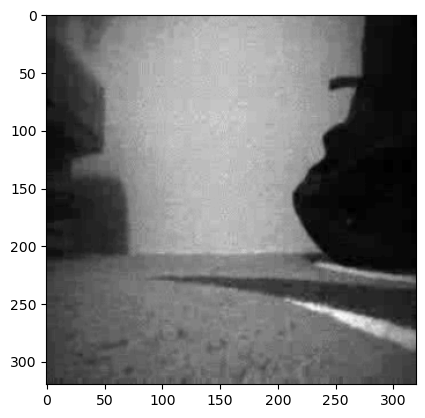

In [3]:
%matplotlib inline 

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
print('Loading video!')
I, frame_rate = load_video(file_name)

print('Making GIF!')
create_gif(I, frame_rate)
print('GIF made!')

Now, we can start processing the images. Your job below is to implement the optical flow algorithm discussed in class. For a single point, $(x, y)$, the window size $w$ is the side length of the box around the pixel. That is define $h = \mathrm{floor}(w / 2)$, then the window is the set of pixels $\{(x', y')\ |\ x - h \leq x' \leq x + h, y - h\leq 'y \leq y + h\}$.

You'll also need to take a number of image derivatives. [There are a lot of ways](https://en.wikipedia.org/wiki/Image_derivatives) one can go about taking them. We'll keep it simple, however, and say that the spatial derivatives $I_x, I_y$ at $(x, y)$ can be computed by subtracting the value at $(x, y)$ from $(x + 1, y + 1)$. Please be sure to note the format of the images (written in the docstring of the function template, below), to make sure that you assign $I_x$ and $I_y$ correctly! For the temporal derivative $I_t$, you can subtract the previous image from the current one.

Using the algorithm as described so far, we'll run into trouble around the border of the image, as there are not enough pixels to create a window or potentially even take a derivative. To handle these cases, we will do the following:

1. Take the image derivatives first. Throw out all pixels for which they are not defined.

2. Create as large a window as possible around the target pixel $(x, y)$. If there are not enough pixels for a complete window, use all the pixels available in the region.

Also, in class, it was discussed that there are cases where the matrix:

$$A^{\mathrm{T}}A = \begin{bmatrix}\sum I_x I_x & \sum I_x I_y\\ \sum I_y I_x & \sum I_y I_y\end{bmatrix}$$

is not invertible. In practice, the determinant of $A^{\mathrm{T}}A$ is unlikely to be exactly zero due to the numerical approximations the computer makes. It may, however, be very small. Since we are solving for two unknowns $u, v$, we need the rank of this matrix to be at least 2. Therefore, we need at least two of the eigenvalues of $A^{\mathrm{T}}A$ to be of a reasonable size. After computing $A$, you should only solve the least-squares problem for $u, v$ if at least two eigenvalues are larger than $0.001$. Otherwise just set $u, v$ to be zero for the point at which you are evaluating the optical flow. You can compute the eigenvalues with Numpy's [eigvals](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigvals.html) function.

Be sure you are using the correct coordinates when accessing the image. It is a common pitfall.

In [40]:
import numpy as np
from scipy import ndimage, datasets
import scipy

def optical_flow_opencv(prev_image: np.ndarray, image: np.ndarray, pts: np.ndarray, win_size: int) -> np.ndarray:
    p0 = pts.reshape(-1,2).astype(np.float32)
    img = (image * 255).astype(np.uint8)
    pimg = (prev_image * 255).astype(np.uint8)
    
    p1, st, err = cv2.calcOpticalFlowPyrLK(pimg, img, p0, None, winSize=(win_size, win_size))
    return p1


def optical_flow(prev_image: np.ndarray, image: np.ndarray, pts: np.ndarray, win_size: int) -> np.ndarray:
    """
    Compute the optical flow between two images using the Lucas-Kanade algorithm.
    
    @param prev_image: The image at time t - 1. Images are represented as arrays of the form I[y, x, t]
                       and are grayscale.
    @param image: The image at time t.
    @param pts: An n-by-2 array of points at which to evaluate the optical flow. Each point is
                 of the form [x, y].
    @param win_size: The size of the window used to compute the flow.
    
    @return: An n-by-2 array whose ith row contains the optical flow at the ith row in pts.
    """
    assert len(pts.shape) == 2, pts.shape
    assert pts.shape[-1] == 2, pts.shape
    img = (image * 255).astype(np.uint8)
    pimg = (prev_image * 255).astype(np.uint8)  
    
    Ix = ndimage.sobel(img, 0)  # horizontal gradient
    Iy = ndimage.sobel(img, 1)  # vertical gradient
    It = image - prev_image
    uvs = []
    for pt in pts:
        xc, yc = pt.astype(int)
        A = np.zeros((win_size**2, 2))
        b = np.zeros((win_size**2))
        ks = win_size // 2
        
        n = 0
        for dx in range(-ks, win_size - ks):
            for dy in range(-ks, win_size - ks):
                h, w = Ix.shape
                x = np.clip(xc + dx, 0, w)
                y = np.clip(yc + dy, 0, h)
                A[n, 0] = Ix[y, x]
                A[n, 1] = Iy[y, x]
                b[n] = -It[y, x]
                n += 1
        result = scipy.optimize.lsq_linear(A, b)
        uv = result.x
        uvs.append(uv)
    uvs = np.array(uvs)
    #print(f"Computed {uvs.shape} opt-flow points ")
    return uvs
                


Now lets apply it to the image. This may take some time to run. In practice, optical flow can be computed extremely quickly, but our code is slow for pedagogical purposes. If you want to just test your code quickly, change the value of `horizon` to some small value like 10. Be sure to change it back before submission, though. You can also play with the `window_size` variable to see how it impacts the computed flow. Please submit your notebook with `window_size = 30` (the default).

In [41]:
window_size = 30

def optical_flow_video(I):
    horizon = I.shape[2]

    # Compute the optical flow at each point.
    flow = np.zeros((I.shape[0] - 1, I.shape[1] - 1, I.shape[2] - 1, 2))

    for t in range(1, horizon):
        if t % 10 == 0:
            print('Completed {0} frames.'.format(t))

        for j in range(0, flow.shape[0], 25):
            for i in range(0, flow.shape[1], 25):
                flow[j, i, t - 1] = optical_flow(I[:, :, t - 1], I[:, :, t], np.array([[i, j]]).astype(float), window_size)

    mean_flow = np.zeros((flow.shape[2], 2))

    # Compute the mean flow at each time step.
    for t in range(mean_flow.shape[0]):
        mean_flow[t, 0] = flow[:, :, t, 0].mean()
        mean_flow[t, 1] = flow[:, :, t, 1].mean()

    plt.plot(np.arange(0, mean_flow.shape[0])*dt, mean_flow[:, 0], label='X Mean')
    plt.plot(np.arange(0, mean_flow.shape[0])*dt, mean_flow[:, 1], label='Y Mean')
    plt.legend()
    return flow

The following cell runs the optical flow defined above.

In [42]:
dt = 0.1

Completed 10 frames.
Completed 20 frames.
Completed 30 frames.
Completed 40 frames.
Completed 50 frames.
Completed 60 frames.
Completed 70 frames.
Completed 80 frames.
Completed 90 frames.
Completed 100 frames.
Completed 110 frames.
Completed 120 frames.
Completed 130 frames.
Completed 140 frames.
Completed 150 frames.
Completed 160 frames.


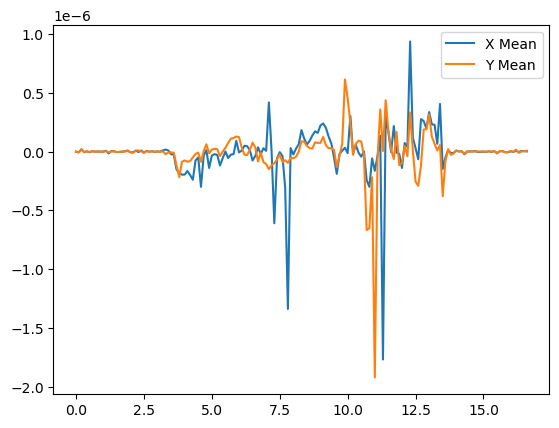

In [43]:
flow = optical_flow_video(I)

Finally, we'll plot some of the optical flow values on top of the video itself. The next cell includes helper functions for visualizing the result from optical flow. **Do not edit this cell!**

In [44]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def visualize_optical_flow(flow, I, frame_rate):
    horizon = I.shape[2]

    fig, ax = plt.subplots()

    cI = np.zeros((I.shape[0], I.shape[1], 3, I.shape[2]))

    for t in range(I.shape[2]):
        cI[:, :, :, t] = cv2.cvtColor((I[:, :, t] * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB).astype(float) / 255

    im = ax.imshow(cI[:, :, :, 0])

    num_arrows = len(range(0, flow.shape[0], 25)) * len(range(0, flow.shape[1], 25))

    cx = np.zeros(num_arrows)
    cy = np.zeros(num_arrows)
    u = np.zeros(num_arrows)
    v = np.zeros(num_arrows)

    k = 0

    for j in range(0, flow.shape[0], 25):
        for i in range(0, flow.shape[1], 25):
            cy[k] = j
            cx[k] = i
            u[k] = 0.1
            v[k] = 0.1
            k += 1   
    
    quiv = ax.quiver(cx, cy, u, v, width=.01)

    def init():
        return [im, quiv]

    def animate(t, window_size):
        boxes = []
        y_windows = int(I.shape[0] / window_size)
        x_windows = int(I.shape[1] / window_size)

        cx = np.zeros(num_arrows)
        cy = np.zeros(num_arrows)
        u = np.zeros(num_arrows)
        v = np.zeros(num_arrows)

        k = 0

        for j in range(0, flow.shape[0], 25):
            for i in range(0, flow.shape[1], 25):
                cy[k] = j
                cx[k] = i

                if np.linalg.norm(flow[j, i, t, :]) > 0.0001:
                    u[k] = 0.1 * flow[j, i, t, 0] / np.linalg.norm(flow[j, i, t, :])
                    v[k] = -0.1 * flow[j, i, t, 1] / np.linalg.norm(flow[j, i, t, :])
                else:
                    u[k] = 0
                    v[k] = 0
                k += 1
        
        ax.clear()
        im = ax.imshow(cI[:, :, :, t])

        colors = np.arctan2(u, v)
        norm = Normalize()
        colormap = cm.hsv
        
        quiv = ax.quiver(cx, cy, u, v, color=colormap(norm(colors)), width=.01)

        return [im, quiv]

    anim = animation.FuncAnimation(fig, lambda t: animate(t, window_size), init_func=init, frames=(horizon - 2), interval=100, blit=True)

    anim.save('./suppl/l7_anim2.gif', writer='pillow', fps=frame_rate)
    Image(url='./suppl/l7_anim2.gif')

The following cell will produce another `.gif` file which has the result from optical flow overlaid on top of your video. Again, if the video isn't playing in jupyter-notebook, it is also saved as a `.gif` in the same directory as this notebook. Please ensure that the `.gif` file plays correctly on your computer.

If you implemented things correctly, there should be a few trends you can observe in the video:
1. Arrows should generally be pointing down when the camera rotates up and pointing up when the camera rotates down.

2. When the camera moves forward (what is known as a "dolly in" motion), the arrows should generally be pointing radially outward (for example, arrows along the bottom of the image should be pointed downward). When the camera moves back ("dolly out"), the arrows should generally move radially inward.

3. Regions of the image without texture may have random arrows, as there are no trackable flow features in those regions.

These phenomena may not appear perfectly. Since the video was filmed by hand, there is some amount of shakiness that contributes to the optical flow. You can also play around with the window size to see whether or not there is improvement.

In [49]:
frame_rate = 5

/home/zimka/.conda/envs/envmae/lib/python3.11/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/zimka/.conda/envs/envmae/lib/python3.11/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


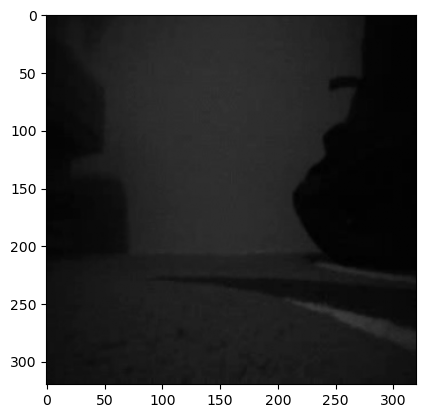

In [50]:
visualize_optical_flow(flow, I, frame_rate)

# Submission Instructions

As usual, you should submit your completed notebook, `anim.gif`, and `anim2.gif` to HW7: Coding on Gradescope.

**Be sure to submit _both_ video files with your notebook!**